In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time

torch.set_printoptions(linewidth=120)

In [0]:
def plot_img(array):
    array = array.detach()
    array = array.reshape(img_x, img_y)
    
    plt.imshow(array, cmap='binary')
    plt.show()
# plot_img(next(iter(train_loader))[0][0])

In [8]:
train_set = torchvision.datasets.FashionMNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [0]:
class Generator(nn.Module):
    
    def __init__(self, inp, out):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(inp, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out),
        )
    
    def forward(self, t):
        t = self.net(t)
        return t

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self, inp, out):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(inp, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, out),
            nn.Sigmoid()
        )
    
    def forward(self, t):
        t = self.net(t)
        return t

In [0]:
# VAR

batch_size = 1000
data_dir = './data/FashionMNIST'
img_x, img_y = 28, 28

d_steps = 1
g_steps = 100

d_lr = 0.001
g_lr = 0.003

random_sample_size = 100

n_epochs = 100
printing_steps = n_epochs//5

make_some_noise = lambda size: torch.rand(batch_size, size)

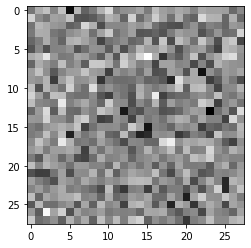

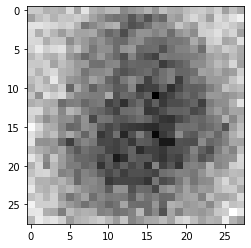

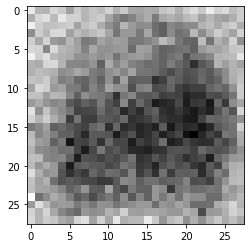

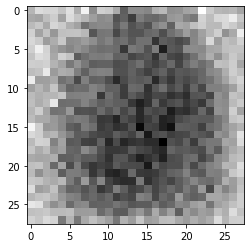

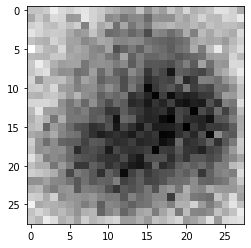

In [14]:
generator = Generator(random_sample_size, img_x*img_y)
g_criterion = nn.BCELoss()
g_optimizer = optim.SGD(generator.parameters(), lr=g_lr, momentum=0.9)


discriminator = Discriminator(img_x*img_y, 1)
d_criterion = nn.BCELoss()
d_optimizer = optim.SGD(discriminator.parameters(), lr=d_lr, momentum=0.9)

# start = time()
data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

for epoch in tqdm(range(n_epochs)):
    
    # print(epoch)
    
    for d_step in range(d_steps):
        
        for real_input, _ in data_loader:
            
            discriminator.zero_grad()
            
            d_real_out = discriminator(real_input.reshape(batch_size, img_x*img_y))
            d_real_loss= d_criterion(
                d_real_out, 
                torch.autograd.Variable(torch.ones(batch_size, 1))
            )
            d_real_loss.backward()

            fake_input = make_some_noise(random_sample_size)
            fake_input = generator(fake_input).detach()

            d_fake_out = discriminator(fake_input)
            d_fake_loss= d_criterion(
                d_fake_out, 
                torch.autograd.Variable(torch.zeros(batch_size, 1))
            )
            d_fake_loss.backward()

            d_optimizer.step()


    for g_step in range(g_steps):
        
        generator.zero_grad()
        
        random_sample = make_some_noise(random_sample_size)
        g_out = generator(random_sample)
        d_out = discriminator(g_out)
        g_loss = g_criterion(
            d_out,
            torch.autograd.Variable(torch.ones(batch_size, 1))
        )
        
        g_loss.backward()
        g_optimizer.step()

    if not epoch % printing_steps:
        plot_img(g_out[0])

# print('total time =', time()-start)